# Defining the best model for ML and DL

## Machine Learning Approach

Import necessary libraries.

In [1]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
# read data
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.metrics
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support as score


Load the training dataset that was created in an earlier script.

In [2]:
ExtPath = r'D:/Python/ucsdmlbc/CommonVoice/archive/'
path = 'AllTrainwithSTD.csv'
df = pd.read_csv(ExtPath + path)
df.drop('Unnamed: 0', inplace = True , axis = 1)

In [3]:
df.head()

,label,spectral_centroid,spectral_bandwidth,spectral_rolloff,mfcc1,Std1,mfcc2,Std2,mfcc3,Std3,...,mfcc8,Std8,mfcc9,Std9,mfcc10,Std10,mfcc11,Std11,mfcc12,Std12
0,us,2679.939301,3347.669230,5745.486746,979.1706,245.34569,376.00223,203.67845,21.370316,165.47630,...,6.797319,12.152376,5.969101,5.031898,-2.055150,11.456238,-9.238556,23.982313,-36.150772,29.230515
1,us,2859.452074,2576.680219,4912.384969,1362.6725,214.69751,426.51360,262.22190,-55.915200,131.02698,...,15.505822,20.660242,7.190213,6.081736,-18.646480,13.818316,-13.789719,28.595057,-37.100063,41.883660
2,us,1976.264151,1830.634203,3344.655227,1490.3817,255.12636,498.77054,206.11307,-168.789950,168.83821,...,16.935290,17.247293,8.798961,7.622944,-3.454667,12.679749,-8.657740,25.217714,-46.766360,39.332394
3,england,2333.763596,2533.282996,4398.824257,1375.0426,237.40717,400.03485,255.08675,66.706030,111.51125,...,14.405625,20.290690,3.268910,6.785762,-6.033383,10.732883,-17.848553,31.696130,-18.436834,33.804314
4,australia,2351.920593,2974.752407,4743.105301,1674.0428,199.60262,530.80383,188.77255,25.876215,102.23092,...,-14.115968,20.496675,-3.055072,6.256124,6.943354,10.071516,2.013073,18.610756,0.343027,34.820515


### The Dataset
The dataset contains information extracted from raw audio files in the CommonVoice dataset found on Kaggle. The features extracted using Librosa are common audio features for ML/DL tasks. The features have been further reduced to a simple average and standard deviation. This took the dataset down from about 1000 features to a much more manageable 27.

In [4]:
le = preprocessing.LabelEncoder()
df['label'] = le.fit_transform(df.label)

This assigns each of the 6 possible classes an integer value which can then be transformed back into its string counterpart after training of the model and the inference.

In [5]:
y_df = df['label'].values
x_df = df.drop('label',axis =1).values
setImbalance = max(df.label.value_counts())
sampling_strategy = {0: setImbalance, 1: setImbalance, 2: setImbalance,3: setImbalance,4: setImbalance,5: setImbalance}
ros = RandomOverSampler(sampling_strategy=sampling_strategy)
x_df, y_df = ros.fit_resample(x_df, y_df)

X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=1500, random_state=42)

Here we wll resample the data due to the large imbalance of US samples. We will sample with replacement of smaller classes until they match the number of samples in the larger set. This is an attempt to take away the "free lunch" that will allow the model to achieve a high accuracy without actually learning.

## Creating the Model

In [6]:
# create model instance
bst = XGBClassifier(tree_method='gpu_hist',
                    gpu_id=0)

Instantiate a XGBoost model with an extremely high eta.

In [7]:
# fit model
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(X_test)

Fit on our train split. Predict on our test split.

In [8]:
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, preds))

Accuracy score 0.8673333333333333


This is an extremely good accuracy for a dataset that was not intitially collected for this purpose.

In [9]:
print(list(zip(le.classes_,f1_score( y_test, preds,average = None))))

[('australia', 0.9461077844311376), ('canada', 0.9083665338645418), ('england', 0.816849816849817), ('indian', 0.9557522123893805), ('other', 0.88), ('us', 0.690423162583519)]


The F1 scores seem to affirm that our model is a great fit for out data.

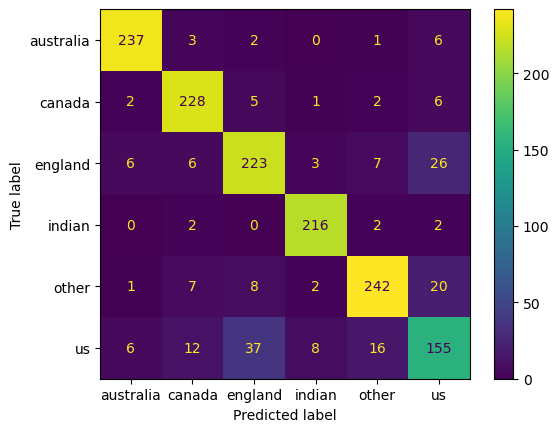

In [10]:
ConfusionMatrixDisplay.from_estimator(bst,X_test, y_test) 
plt.yticks(list(range(6)), le.classes_)
plt.xticks(list(range(6)), le.classes_)
plt.show()

The confusion matrix shows that there are minor issues predicting between english and us.

## Loading in the Holdout set
This will provide further validation that our model selection and parameters are correct.

In [11]:
path = 'AllTestwithSTD.csv'
tdf = pd.read_csv(ExtPath + path)
tdf.drop('Unnamed: 0', inplace = True , axis = 1)

In [12]:
tdf.head()

,label,spectral_centroid,spectral_bandwidth,spectral_rolloff,mfcc1,Std1,mfcc2,Std2,mfcc3,Std3,...,mfcc8,Std8,mfcc9,Std9,mfcc10,Std10,mfcc11,Std11,mfcc12,Std12
0,us,2989.352534,3339.757694,5928.812241,1070.9161,286.77866,359.35046,256.33795,64.704390,136.94075,...,10.516781,17.959404,-3.883029,5.293398,-5.710344,11.083928,-17.474850,30.463350,-23.130020,31.321636
1,us,2133.837000,2207.336507,3960.401173,1531.2106,220.63615,446.88640,239.07928,25.928629,91.34565,...,-4.587084,15.005417,-3.340641,5.584820,-10.501137,13.503418,-25.604900,41.803677,-6.883898,32.595720
2,england,2521.102006,1905.139312,4272.600446,1704.9707,259.72937,465.13617,279.39984,-55.900300,172.24391,...,17.141512,22.572805,1.076097,6.331244,9.164820,13.704433,-71.791250,40.602120,-40.188183,37.455463
3,us,2671.489951,2733.928177,4713.298112,1509.9088,321.67624,469.32346,263.20477,-83.308320,138.15361,...,-13.213719,22.282640,6.017400,5.678208,-12.766272,11.620600,-3.396441,31.158504,-36.797770,43.210537
4,other,2688.984365,2766.801820,5267.713134,1411.5352,253.50493,396.91510,211.12108,-37.508797,128.46094,...,8.582016,20.448800,-1.915302,2.872806,4.211450,8.148054,-17.958584,26.262750,-7.847155,32.220670


This dataset has the same form as before but is data that the model has for sure never seen before.

In [13]:
tdf['label'] = le.transform(tdf.label)

Tranfrom our labels to their integer counterparts.

In [14]:
tpreds = bst.predict(tdf.drop('label',axis = 1))

Create predictions based on the model that was created.

In [15]:
print("Accuracy score", sklearn.metrics.accuracy_score(tdf['label'], tpreds))

Accuracy score 0.6771300448430493


The accuracy score for the holdout set is much lower than the validation set. This mean that the model is overfitting but 78.6% accuracy is still fairly good.

In [16]:
print(list(zip(le.classes_,f1_score( tdf['label'], tpreds,average = None))))

[('australia', 0.6310160427807486), ('canada', 0.584), ('england', 0.6771653543307087), ('indian', 0.635897435897436), ('other', 0.6044776119402986), ('us', 0.7291849255039439)]


Our F1 scores show that there are some major issues with a few of the accents.

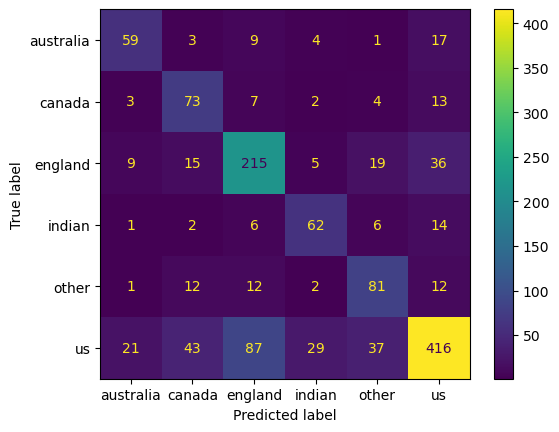

In [17]:
ConfusionMatrixDisplay.from_estimator(bst,tdf.drop('label',axis = 1), tdf['label']) 
plt.yticks(list(range(6)), le.classes_)
plt.xticks(list(range(6)), le.classes_)
plt.show()

Our model appears to have trouble with Australians, canadians and the other categories. The best way to fix this would be to have more samples and a heavily validated dataset to make sure that samples are labeled properly.

## Tuning XGBoost

In [18]:
from sklearn.model_selection import StratifiedKFold,cross_val_score
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

Import libraries for automated tuning.

In [19]:
# Space
space = {
    'learning_rate': hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.1, 1]),
    'max_depth' : hp.choice('max_depth', range(3,19,3)),
    'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),     
    'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]), 
    'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100]),
    'eta' : hp.choice('eta', [.1,.2,.3,.6,.8,1])
}

Create a search space for Hyperopt to look over.

In [20]:
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

Create a Stratified K Fold cross valdation to ensure we dont accidentally create bias.

In [21]:
# Objective function
def objective(params):
    
    xgboost = XGBClassifier(seed=0, 
                            tree_method='gpu_hist',
                            gpu_id=0,
                            **params)
    score = cross_val_score(estimator=xgboost, 
                            X=X_train, 
                            y=y_train, 
                            cv=kfold, 
                            scoring='f1_macro',
                            n_jobs = -1
                            ).mean()
    # Loss is negative score
    loss = - score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

Setup the function that will be used to train each model and produce a score.

In [22]:
# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 15, trials = Trials())

100%|██████████| 15/15 [10:04<00:00, 40.31s/trial, best loss: -0.9674183816767093]


Use Hyperopt to do a bayesian search for the best parameters in the search space. Hyperopt will try to minimize the loss so we must use the negative of the F1.

In [23]:
# Print the index of the best parameters
print(best)
# Print the values of the best parameters
print(space_eval(space, best))

{'colsample_bytree': 4, 'eta': 2, 'gamma': 4, 'learning_rate': 3, 'max_depth': 4, 'reg_alpha': 1, 'reg_lambda': 0}
{'colsample_bytree': 0.7, 'eta': 0.3, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 15, 'reg_alpha': 0.01, 'reg_lambda': 1e-05}


Output our best parameters.

In [24]:
# Train model using the best parameters
xgboost_bo = XGBClassifier(seed=0, 
                           colsample_bytree=space_eval(space, best)['colsample_bytree'], 
                           gamma=space_eval(space, best)['gamma'], 
                           learning_rate=space_eval(space, best)['learning_rate'], 
                           max_depth=space_eval(space, best)['max_depth'], 
                           reg_alpha=space_eval(space, best)['reg_alpha'],
                           reg_lambda=space_eval(space, best)['reg_lambda'],
                           eta = space_eval(space, best)['eta'],
                           num_parallel_tree = 5,
                           tree_method='gpu_hist',
                            gpu_id=0,
                           ).fit(X_train,y_train)
# Make prediction using the best model
bayesian_opt_predict = xgboost_bo.predict(X_test)
# Get predicted probabilities
bayesian_opt_predict_prob = xgboost_bo.predict_proba(X_test)[:,1]
# Get performance metrics
precision, recall, fscore, support = score(y_test, bayesian_opt_predict)

Training a model using the best parameters from the Hyperopt search.

In [25]:
Scores = pd.DataFrame(data = np.array(score(y_test, bayesian_opt_predict)).T,
    index = le.classes_,
             columns = ['Precision','Recall','F Score','Support'])
print(Scores)

           Precision    Recall   F Score  Support
australia   1.000000  1.000000  1.000000    249.0
canada      1.000000  1.000000  1.000000    244.0
england     0.956522  0.974170  0.965265    271.0
indian      1.000000  1.000000  1.000000    222.0
other       0.992883  0.996429  0.994652    280.0
us          0.969298  0.944444  0.956710    234.0


Looking at the precision recall and F score for the validation set. As before this also suggests our model is very good.

### Testing our new model on the Holdout set

In [26]:
print("Accuracy score", sklearn.metrics.accuracy_score(tdf['label'], xgboost_bo.predict(tdf.drop('label',axis = 1))))

Accuracy score 0.7862481315396114


The Accuracy score has improved significantly. This may be reaching the maximum accuracy possible with a ML algorithm.

In [27]:
f1_score( tdf['label'], xgboost_bo.predict(tdf.drop('label',axis = 1)),average = None)

array([0.70748299, 0.69512195, 0.76736111, 0.71052632, 0.72115385,
       0.82995101])

Once again the F1 scores indicate that our model is having trouble with a few of the classes but has improved over the baseline model.

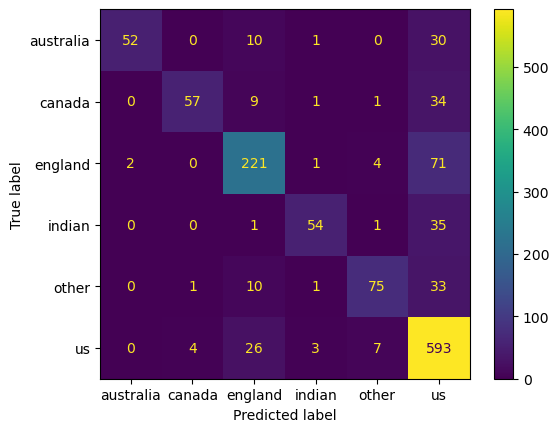

In [28]:
ConfusionMatrixDisplay.from_estimator(xgboost_bo,tdf.drop('label',axis = 1), tdf['label']) 
plt.yticks(list(range(6)), le.classes_)
plt.xticks(list(range(6)), le.classes_)
plt.show()

The confusion matrix again shows the difficulties with australia and canada. The remaining classes have improved to an acceptable level.

In [29]:
xgboost_bo.save_model('XGBTuned.model')

Save the model

### Visualizing the model

In [30]:
from xgboost import plot_tree
from xgboost import to_graphviz
import matplotlib.pyplot as plt

In [31]:
format = 'svg'
image = to_graphviz(xgboost_bo, num_trees=0, rankdir='LR')
#image.graph_attr = {'dpi':'400'}
image.render('XGBoostModelView', format = format)

'XGBoostModelView.svg'

Model view is too large to view in Jupyter so it will not be shown here. To view open repository.

# Deep Learning Model

In [32]:
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

Import deep learning libraries.

In [33]:
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

Scale the data to be in a normalized range for optimal trainnig of the deep learning algorithm. This helps with weight imbalances.

In [34]:
encoder = OneHotEncoder(handle_unknown="ignore")
encoder.fit(y_train.reshape(-1,1))

OneHotEncoder(handle_unknown='ignore')

One hot encode the labels so we can use a 6 node output to our algorithm and provide more seperation between the predictions made.

In [35]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(len(x_df[0]),)),
  tf.keras.layers.Dense(64,activation='elu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(256,activation='relu'),
  tf.keras.layers.Dense(512,activation='swish'),
  tf.keras.layers.Dense(256,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(6,activation= 'softmax')
])

Create the model. Here we are using a very simple sequential model, the acctvation functions and layer size were found through trial and error and could be optimize more. This setup uses a softmax on the output to provide a clear prediction result.

In [36]:
model.compile(optimizer='adamax',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

Compile the model. Here we use adamax, other optimization functions were tried but ultimately made little difference. Accuracy and MSE were chosen due to their simplicity. 

In [37]:
model.fit(scaler.transform(X_train),
          encoder.transform(y_train.reshape(-1,1)).todense(),
          epochs=50,
          batch_size = 126,
          validation_data = (scaler.transform(X_test), encoder.transform(y_test.reshape(-1,1)).todense()))

Epoch 1/50
1465/1465 [==============================] - 8s 5ms/step - loss: 0.1242 - accuracy: 0.3420 - val_loss: 0.1100 - val_accuracy: 0.4667
Epoch 2/50
1465/1465 [==============================] - 7s 5ms/step - loss: 0.0968 - accuracy: 0.5442 - val_loss: 0.0848 - val_accuracy: 0.6080
Epoch 3/50
1465/1465 [==============================] - 7s 5ms/step - loss: 0.0785 - accuracy: 0.6461 - val_loss: 0.0720 - val_accuracy: 0.6807
Epoch 4/50
1465/1465 [==============================] - 7s 5ms/step - loss: 0.0665 - accuracy: 0.7078 - val_loss: 0.0606 - val_accuracy: 0.7327
Epoch 5/50
1465/1465 [==============================] - 7s 5ms/step - loss: 0.0577 - accuracy: 0.7505 - val_loss: 0.0545 - val_accuracy: 0.7600
Epoch 6/50
1465/1465 [==============================] - 7s 5ms/step - loss: 0.0503 - accuracy: 0.7850 - val_loss: 0.0443 - val_accuracy: 0.8133
Epoch 7/50
1465/1465 [==============================] - 7s 5ms/step - loss: 0.0445 - accuracy: 0.8130 - val_loss: 0.0409 - val_accuracy:

Training the model we can see that the training accuracy was 98% and validation was 96% this is much better than the tree model and an overall good result.

### Deep Learning Model Performance on the Holdout set

In [38]:
print("Accuracy score", sklearn.metrics.accuracy_score(tdf['label'],model.predict(scaler.transform(tdf.drop('label',axis=1).values)).argmax(1)))

42/42 [==============================] - 0s 2ms/step
Accuracy score 0.8393124065769806


The models accuracy is not what it was during training and suggests an overfit. The model may benefit from different layer types or less nodes.

In [39]:
Scores = pd.DataFrame(data = np.array(score(tdf.label,model.predict(scaler.transform(tdf.drop('label',axis=1).values)).argmax(1))).T
             ,index = le.classes_,
             columns = ['Precision','Recall','F Score','Support'])
print(Scores)

42/42 [==============================] - 0s 1ms/step
           Precision    Recall   F Score  Support
australia   0.841463  0.741935  0.788571     93.0
canada      0.766990  0.774510  0.770732    102.0
england     0.793651  0.836120  0.814332    299.0
indian      0.872093  0.824176  0.847458     91.0
other       0.833333  0.833333  0.833333    120.0
us          0.870253  0.868878  0.869565    633.0


The above table shows that there is a noticeable improvement over a the ML model.

42/42 [==============================] - 0s 1ms/step


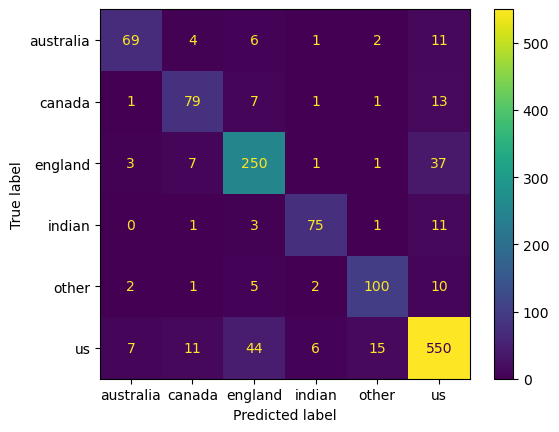

In [40]:
ConfusionMatrixDisplay.from_predictions(tdf.label.values,model.predict(scaler.transform(tdf.drop('label',axis=1).values)).argmax(1))
plt.yticks(list(range(6)), le.classes_)
plt.xticks(list(range(6)), le.classes_)
plt.show()

The confusion matrix shows that most errors involve US accents.

In [41]:
model.save('DL.h5')

Save the DL Model.

# Conclusion
The deep learning model produced an overall better result. The precsion, recall and F Scores all improved when using hyperopt on the cutting edge XGBoost Classifier but were still beat by the Tensorflow deep learning model. For my final project I will implement the DL model unless scaling up the Trees model improves the generalization of the model. Both models appear to be overfittnig the training data, this is hard to deal with due to the massive imbalance in the original dataset. Controlling the depth of the tree's model should have helped improve the overfitting but it ended up just reducing overall performance. There is most likely an issue with the labelling in the underlying dataset, it was not collected for the strict use of accent recognition and is user labeled with minimal pre-validation. It is possible that the 'error' in the models prediction is actually the proper accent for the sample.